In [2]:
from tensorflow import keras
import tensorflow_datasets.public_api as tfds
import tensorflow as tf
import pathlib

Создаём датасет с цветочками

In [17]:
# (лучше загрузить свой с инета)
data_dir = tf.keras.utils.get_file(origin="C:\\Users\\samki\\Downloads\\flowers.zip",
                                   fname="flower_photos",
                                   untar=True)
data_dir = pathlib.Path(data_dir)

# Константы
batch_size = 32
img_height = 150
img_width = 150

# Разбиваем датасет на тренировочную группу и группу валидации
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=5432,
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=5432,
)


train_data = train_data.map(lambda x, y: (x / 255.0, x / 255.0))
validation_data = validation_data.map(lambda x, y: (x / 255.0, x / 255.0))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Модель

In [24]:
from tensorflow import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Reshape, Dense, Cropping2D

# Модель
input_shape = (img_height, img_width, 3)
latent_dim = 8

# Кодировщик
encoder_inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_inputs)
x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(4, (3, 3), activation="relu", padding="same")(x)
x = Flatten()(x)
x = Dense(latent_dim*4, activation="relu")(x)
x = Dense(latent_dim*2, activation="relu")(x)
latent_vector = Dense(latent_dim, activation="sigmoid")(x)
encoder = keras.Model(encoder_inputs, latent_vector, name="encoder")

# Декодировщик
latent_inputs = Input(shape=(latent_dim,))
x = Dense(20 * 20 * 32, activation="sigmoid")(latent_inputs)
x = Reshape((20, 20, 32))(x)
x = Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(16, (3, 3), activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(8, (3, 3), activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)
decoder_outputs = Cropping2D((5, 5))(decoder_outputs)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Автоэнкодер
autoencoder_inputs = Input(shape=input_shape)
latent_vector = encoder(autoencoder_inputs)
autoencoder_outputs = decoder(latent_vector)
autoencoder = keras.Model(autoencoder_inputs, autoencoder_outputs, name="autoencoder")
autoencoder.compile(loss="mae", optimizer="rmsprop")

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 encoder (Functional)        (None, 8)                 2887668   
                                                                 
 decoder (Functional)        (None, 150, 150, 3)       130451    
                                                                 
Total params: 3,018,119
Trainable params: 3,018,119
Non-trainable params: 0
_________________________________________________________________


In [25]:
autoencoder.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
)

Epoch 1/20
92/92 [==============================] - 11s 115ms/step - loss: 0.2432 - val_loss: 0.2393
Epoch 2/20
92/92 [==============================] - 10s 113ms/step - loss: 0.2376 - val_loss: 0.2351
Epoch 3/20
92/92 [==============================] - 10s 114ms/step - loss: 0.2342 - val_loss: 0.2306
Epoch 4/20
92/92 [==============================] - 10s 113ms/step - loss: 0.2262 - val_loss: 0.2238
Epoch 5/20
92/92 [==============================] - 10s 113ms/step - loss: 0.2113 - val_loss: 0.2009
Epoch 6/20
92/92 [==============================] - 10s 113ms/step - loss: 0.2049 - val_loss: 0.2020
Epoch 7/20
92/92 [==============================] - 10s 113ms/step - loss: 0.2020 - val_loss: 0.1992
Epoch 8/20
92/92 [==============================] - 10s 113ms/step - loss: 0.2000 - val_loss: 0.1956
Epoch 9/20
92/92 [==============================] - 10s 113ms/step - loss: 0.1967 - val_loss: 0.1895
Epoch 10/20
92/92 [==============================] - 10s 113ms/step - loss: 0.1940 - val_lo

23/23 [==============================] - 1s 30ms/step


TypeError: 'OwnedIterator' object is not subscriptable

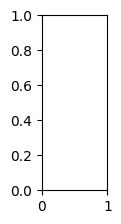

In [28]:
import matplotlib.pyplot as plt

# Генерация изображений с помощью автоэнкодера
generated_images = autoencoder.predict(validation_data)
num_images = 10

# Отображение сгенерированных изображений
plt.figure(figsize=(10, 5))
for i in range(num_images):
    # Исходное изображение
    plt.subplot(2, num_images, i + 1)
    plt.imshow(validation_data[i])
    plt.title('Original')
    plt.axis('off')

    # Сгенерированное изображение
    plt.subplot(2, num_images, i + num_images + 1)
    plt.imshow(generated_images[i])
    plt.title('Generated')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Пример использования
plot_generated_images(autoencoder, validation_data)